# Develop adafilt.optimal

In [1]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2
import numpy as np
import adafilt as af
from scipy.signal import csd
from adafilt.utils import olafilt
from response import Response
import matplotlib.pyplot as plt

n = 1024
p = [1, 0, 1, 0]
g = [0, 1, 0, 0]
x = np.random.random(2**18)
d = olafilt(p, x)

In [2]:
nfft = None
if g is None:
    G = np.ones(n)
else:
    G = np.fft.fft(g, n=n)
if nfft is None:
    nfft = n

_, Sxd = csd(x, d, nperseg=n, return_onesided=False)
_, Sxx = csd(x, x, nperseg=n, return_onesided=False)

wopt = - Sxd / Sxx / G

c = np.ones(nfft)
c[nfft // 2:] = 0
# half at DC and Nyquist
c[0] = 0.5
if nfft % 2 == 0:
    c[nfft // 2] = 0.5

# minimum phase and allpass components of G
Gmin = np.exp(np.fft.fft(c * np.fft.ifft(2 * np.log(np.abs(G)), n=nfft), n=n))
Gall = G / Gmin

# spectral factor
F = np.exp(np.fft.fft(c * np.fft.ifft(np.log(Sxx), n=nfft), n=n))

h = np.ones(nfft)
h[nfft // 2:] = 0
woptcon = - np.fft.fft(h * np.fft.ifft(Sxd / F.conj() / Gall), n=n) / (F * Gmin)

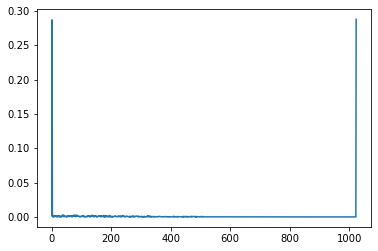

In [3]:
plt.plot(np.abs(np.fft.ifft(Sxd / F.conj() / Gall)))

minimum phase and allpass component

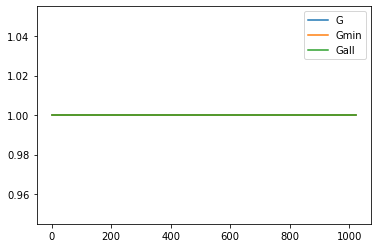

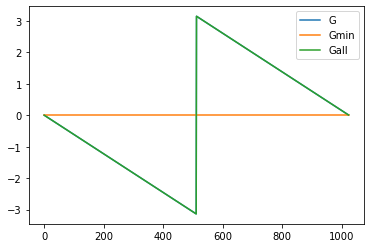

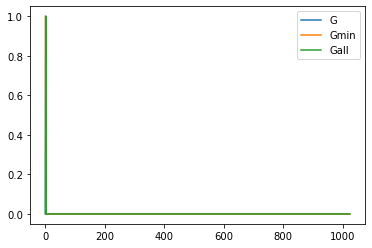

In [4]:
plt.plot(np.abs(G), label="G")
plt.plot(np.abs(Gmin), label=("Gmin"))
plt.plot(np.abs(Gall), label=("Gall"))
plt.legend()

plt.figure()
plt.plot(np.angle(G), label="G")
plt.plot(np.angle(Gmin), label=("Gmin"))
plt.plot(np.angle(Gall), label=("Gall"))
plt.legend()

plt.figure()
plt.plot(np.real(np.fft.ifft(G)), label="G")
plt.plot(np.real(np.fft.ifft(Gmin)), label=("Gmin"))
plt.plot(np.real(np.fft.ifft(Gall)), label=("Gall"))
plt.legend()


Spectral factors

True

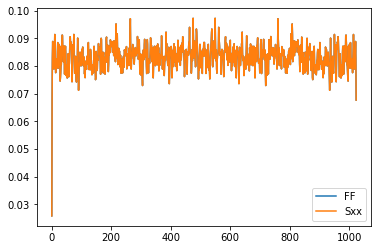

In [5]:
plt.plot(np.abs(F*F.conj()), label=("FF"))
plt.plot(np.abs(Sxx), label=("Sxx"))
plt.legend()

np.allclose(F*F.conj(), Sxx)

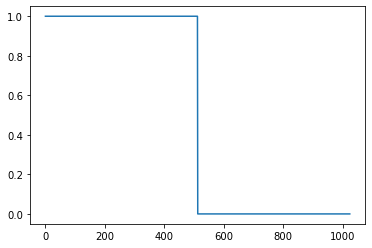

In [6]:
plt.plot(h)

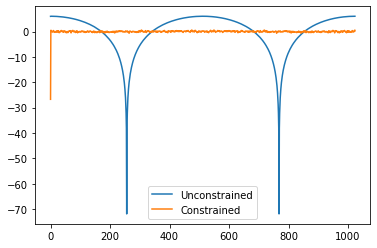

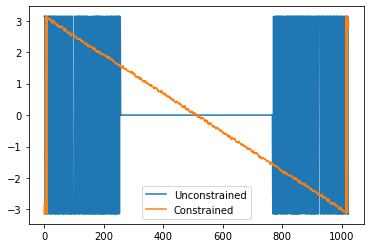

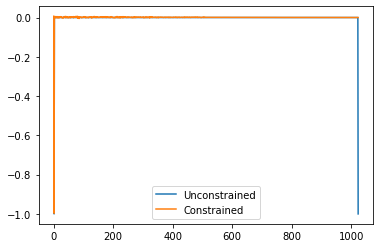

In [7]:
plt.plot(20 * np.log10(np.abs(wopt)), label="Unconstrained")
plt.plot(20 * np.log10(np.abs(woptcon)), label="Constrained")
plt.legend()

plt.figure()
plt.plot(np.angle(wopt), label="Unconstrained")
plt.plot(np.angle(woptcon), label="Constrained")
plt.legend()

plt.figure()
plt.plot(np.real(np.fft.ifft(wopt)), label="Unconstrained")
plt.plot(np.real(np.fft.ifft(woptcon)), label="Constrained")
plt.legend()

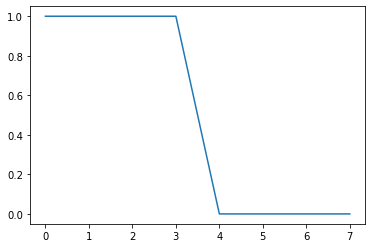

In [8]:
h = np.ones(8)
h[8 // 2:] = 0
plt.plot(h)

## Test 1d

Compare optimal wiener filter and multichannel optimal wiener filter.

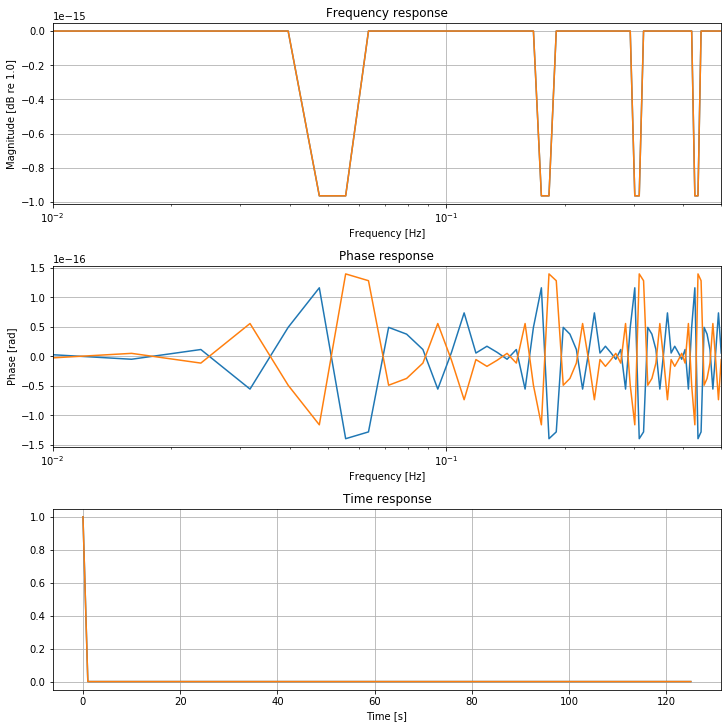

(True, True)

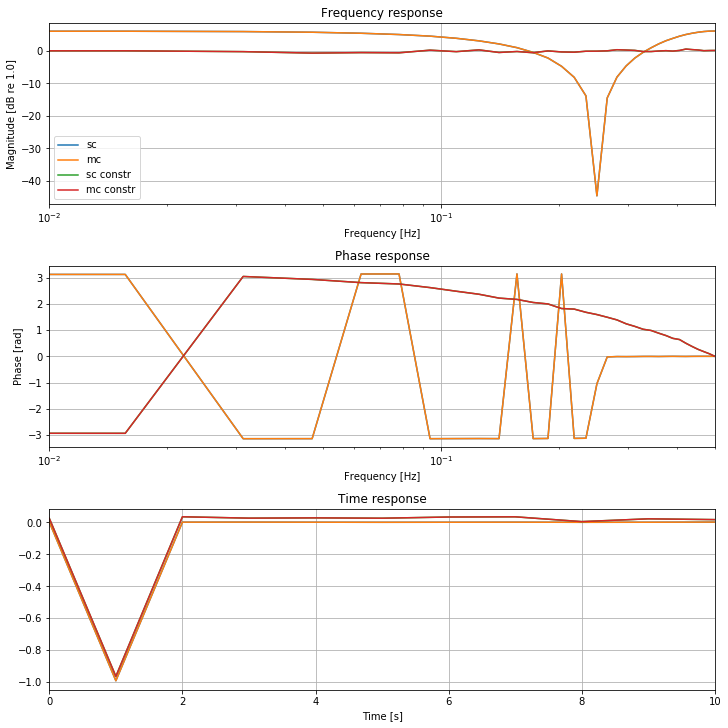

In [18]:
from adafilt.optimal import wiener_filter, multi_channel_wiener_filter, static_filter

n = 16
p = [1, 0, 1]
g = [0, 1, 0]
x = np.random.random(2**14)
d = olafilt(p, x)

nfilt = n * 4
wopt = wiener_filter(x, d, nfilt, g)
woptmc = multi_channel_wiener_filter(x, d, nfilt, g)
woptcon = wiener_filter(x, d, nfilt, g, constrained=True)
woptconmc = multi_channel_wiener_filter(x, d, nfilt, g, constrained=True)

fig = Response.from_freq(1, wopt[:nfilt // 2 + 1]).plot(label="sc")
Response.from_freq(1, woptmc[:nfilt // 2 + 1].T).plot(use_fig=fig, label="mc");
Response.from_freq(1, woptcon[:nfilt // 2 + 1]).plot(use_fig=fig, label="sc constr")
Response.from_freq(1, woptconmc[:nfilt // 2 + 1].T).plot(use_fig=fig, flim=(1e-2, 0.5), tlim=(0, 10), label="mc constr");

np.allclose(woptcon, woptconmc[:, 0, 0]), np.allclose(wopt, woptmc[:, 0, 0])

## Test 2d

multichennal wiener with causal constrained. Hard to get working. Spectral Factors of matrix???

In [ ]:
def multi_channel_wiener_filter(x, d, n, g=None, constrained=False, rho=0, beta=0):
    """Compute multichannel optimal wiener filter.

    From Elliot, Signal Processing for Optimal Control, Eq. 5.3.31

    Parameters
    ----------
    x : array_like, shape (N1[, K])
        K reference signals.
    d : array_like, shape (N2[, L])
        L disturbance signals.
    n : int
        Output filter length.
    g : None or array_like, shape (N3[, L[, M]]), optional
        Secondary path impulse response.
    constrained : bool, optional
        If True, constrain filter to be causal.
    rho: float
        Regularize through control effort weighting.
    beta: float
        Regularize through reference noise.

    Returns
    -------
    numpy.ndarray, shape (n,[, M])
        Optimal wiener filter in freqency domain.

    """
    if g is None:
        g = [1]

    x = atleast_2d(x)
    d = atleast_2d(d)
    g = atleast_3d(g)

    Nin = x.shape[1]
    _, Nmic, Nout = g.shape

    G = np.fft.fft(g, n=n, axis=0)

    Sxx = np.zeros((n, Nin, Nin), dtype=complex)
    for i in range(Nin):
        for j in range(Nin):
            _, S = csd(x[:, i], x[:, j], nperseg=n, return_onesided=False)
            Sxx[:, i, j] = S

    Sxd = np.zeros((n, Nmic, Nin), dtype=complex)
    for i in range(Nmic):
        for j in range(Nin):
            _, S = csd(x[:, j], d[:, i], nperseg=n, return_onesided=False)
            Sxd[:, i, j] = S

    if not constrained:
        return - np.linalg.pinv(G) @ Sxd @ np.linalg.pinv(Sxx + beta * np.identity(Nin))

    def hermtrans(x):
        return x.conj().transpose([0, 2, 1])

    def spectral_factor(x):
        c = np.ones((n, 1, 1))
        c[n // 2:] = 0
        # half at DC and Nyquist
        c[0] = 0.5
        if n % 2 == 0:
            c[n // 2] = 0.5
        return np.exp(np.fft.fft(c * np.fft.ifft(np.log(x), axis=0), axis=0))

    # spectral factor of G.H @ G is Gmin.H
    #print(np.log(hermtrans(G) @ G + rho * np.identity(Nout)))
    Gmin = hermtrans(spectral_factor(hermtrans(G) @ G + rho * np.identity(Nout)))

    # from response import Response
    # fig = Response.from_freq(1, Gmin.T).plot()
    Gmin = spectral_factor(hermtrans(G) @ G + rho * np.identity(Nout))
    #print(Gmin)
    # Response.from_freq(1, Gmin.T).plot(use_fig=fig, show=True, flim=(1e-2, 0.5))
    Gall = G @ np.linalg.pinv(Gmin)

    # spectral factor if Sxx
    invF = np.linalg.pinv(spectral_factor(Sxx + beta * np.identity(Nin)))

    h = np.ones((n, 1, 1))
    h[n // 2:] = 0
    GhSFinvh = hermtrans(Gall) @ Sxd @ hermtrans(invF)
    GhSFinvh = np.fft.fft(h * np.fft.ifft(GhSFinvh, axis=0), axis=0)  # remove causal part
    return - np.linalg.pinv(Gmin) @ GhSFinvh @ invF

/home/fhchl/Dropbox/Software/adafilt/adafilt/optimal.py:163: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.fft.fft(c * np.fft.ifft(np.log(x), axis=0), axis=0))
/home/fhchl/Dropbox/Software/adafilt/adafilt/optimal.py:163: RuntimeWarning: invalid value encountered in multiply
  return np.exp(np.fft.fft(c * np.fft.ifft(np.log(x), axis=0), axis=0))


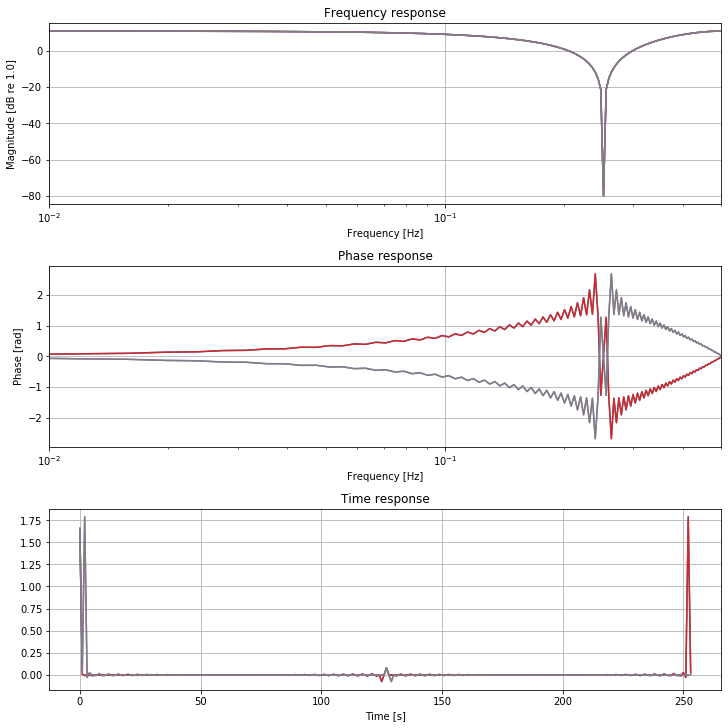

/home/fhchl/miniconda3/envs/sfc2/lib/python3.7/site-packages/numpy/linalg/linalg.py:1974: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
/home/fhchl/Dropbox/Software/response/response.py:367: RuntimeWarning: divide by zero encountered in log10
  20 * np.log10(np.abs(freq_plotready / dbref)),


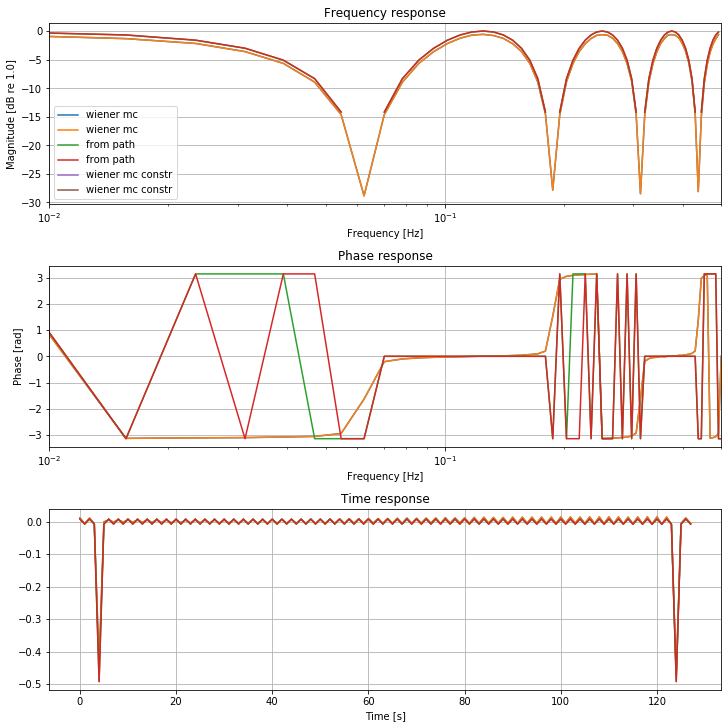

In [19]:
n = 32
Nin = 1
Nout = 2
Nmic = 3
# primary path
p = np.zeros((n, Nmic))
p[[8,9,  16, 17]] = 1

# secondary path
g = np.zeros((n, Nmic, Nout))
g[[12, 13]] = 1

# signal
x = np.random.normal(size=(2**18, Nin))
d = olafilt(p, x)

nfilt = 4 * n
Wsigcon = multi_channel_wiener_filter(x, d, nfilt, g, constrained=True, rho=1e-8)
Wsig = multi_channel_wiener_filter(x, d, nfilt, g, constrained=False)
Wpath = static_filter(p, g, nfilt)

fig = Response.from_freq(1, Wsig[:nfilt // 2 + 1].T).plot(label="wiener mc");
Response.from_freq(1, Wpath[:nfilt // 2 + 1].T).plot(use_fig=fig, label="from path");
Response.from_freq(1, Wsigcon[:nfilt // 2 + 1].T).plot(use_fig=fig, flim=(1e-2, 0.5), label="wiener mc constr");

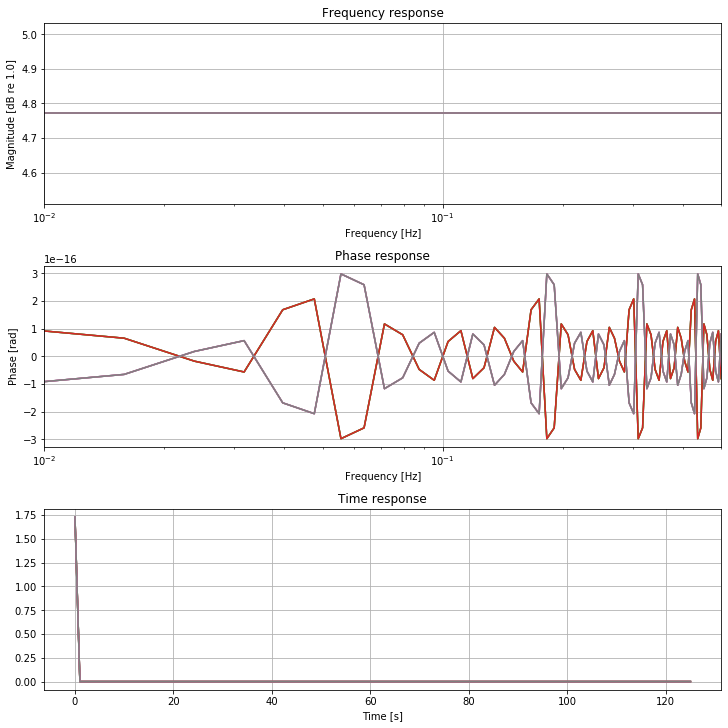

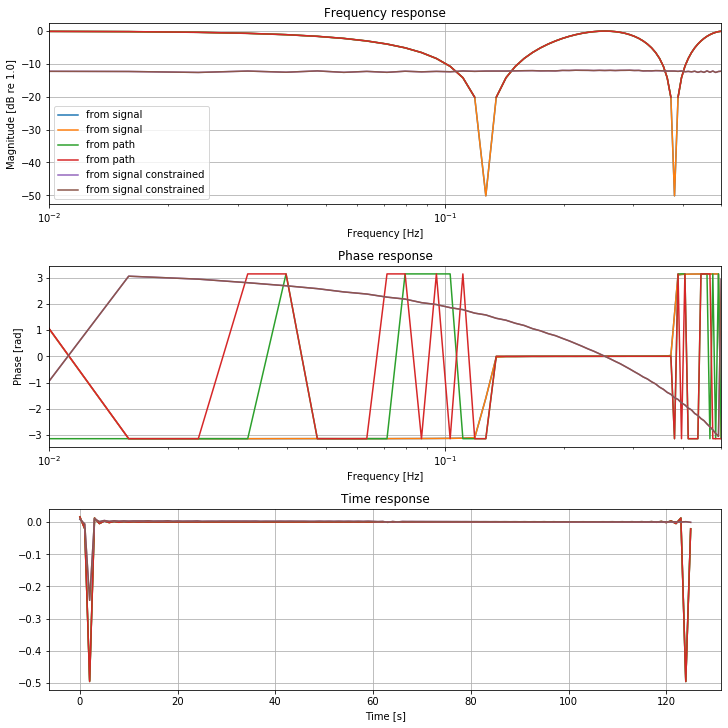

In [20]:
n = 16
Nin = 1
Nout = 2
Nmic = 3
# primary path
p = np.zeros((n, Nmic))
p[[0, 2]] = 1

# secondary path
g = np.zeros((n, Nmic, Nout))
g[1] = 1

# signal
x = np.random.normal(size=(2**18, Nin))
d = olafilt(p, x)

nfilt = 4 * n
Wsigcon = multi_channel_wiener_filter(x, d, nfilt, g, constrained=True)
Wsig = multi_channel_wiener_filter(x, d, nfilt, g, constrained=False)
Wpath = static_filter(p, g, nfilt)

fig = Response.from_freq(1, Wsig[:nfilt].T).plot(flim=(1e-2, 0.5), label="from signal");
Response.from_freq(1, Wpath[:nfilt].T).plot(use_fig=fig, flim=(1e-2, 0.5), label="from path");
Response.from_freq(1, Wsigcon[:nfilt].T).plot(use_fig=fig, flim=(1e-2, 0.5), label="from signal constrained");

# Develop adafilt.MultiChannelBlockFxLMS

In [3]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from adafilt import MultiChannelBlockFxLMS
from adafilt.utils import olafilt
from adafilt.optimal import multi_channel_wiener_filter
from response import Response

n = 16
Nin = 2
Nout = 3
Nsens = 4

# primary path
h_pri = np.zeros((n, Nsens))
h_pri[0] = 1

# secondary path
h_sec = np.zeros((n, Nsens, Nout))
h_sec[0] = 1

# signal
x = np.random.normal(size=(2**18, Nin))
d = olafilt(h_pri, x)

Optimal Wiener filter

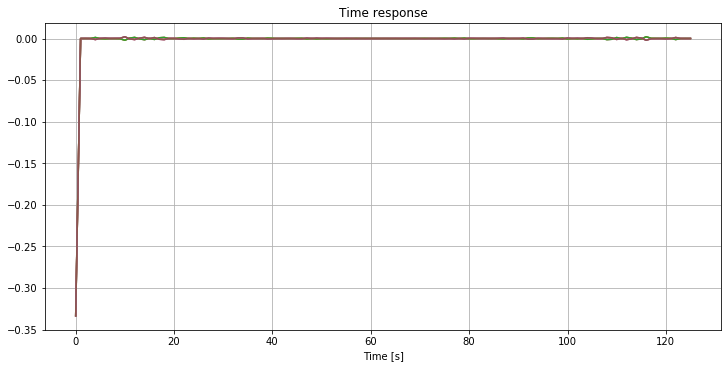

In [5]:
nfilt = 4 * n
wiener = multi_channel_wiener_filter(x, d, nfilt, h_sec, constrained=False)

Response.from_freq(1, wiener[:nfilt+1].T).plot_time();

In [4]:
zifilt = np.zeros((2 * length - 1, 1))
for i in range(n_buffers):

    x = np.random.normal(size=(blocklength, Nin))
    d = primary_path(x)
    
    y, zifilt = olafilt(w, x, zi=self.zifilt, squeeze=False)
    
    # adapt filter
    filt.adapt(x, e)
    
    u = secondary_path(y)
    e = d - u
    
    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)

NameError: name 'length' is not defined

In [6]:
from adafilt import SimpleFilter

blocklength = n  # length of I/O buffer and blocksize of filter
n_buffers = 150  # size of simulation

# white noise signal
signal = np.random.normal(0, 1, size=n_buffers * blocklength)

# the adaptive filter
filt = MultiChannelBlockFxLMS(
    Nout=Nout,
    Nin=Nin,
    Nsens=Nsens,
    length=nfilt,
    blocklength=blocklength,
)

# secondary path estimate has to account for block size
primary_path = SimpleFilter(h_pri, squeeze=False)
secondary_path = SimpleFilter(h_sec, squeeze=False)
plant_model = SimpleFilter(np.concatenate((np.zeros((blocklength, Nsens, Nout)), h_sec)), sum_inputs=False, squeeze=False)

# aggregate signals during simulation
xlog = []
elog = []
wslog = []
ylog = []
fxlog = []

y = np.zeros((blocklength, Nout))  # control signal is zero for first block
for i in range(n_buffers):

    x = np.random.normal(size=(blocklength, Nin))
    d = primary_path(x)
    u = secondary_path(y)
    e = d - u
    
    # adapt filter
    filt.adapt(x, e)
    
    # filter
    y = filt.filt(x)
    
    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)

plt.title("Final filter")
plt.plot(filt.w.reshape(nfilt, -1))
plt.xlabel("Tap")

plt.figure()
plt.title("Error Energy")
plt.plot(10 * np.log10(np.array(np.concatenate(elog)) ** 2))
plt.xlabel("Sample")
plt.ylabel("Error [dB]")

plt.figure()
plt.title("output")
plt.plot(np.concatenate(ylog))
plt.xlabel("Sample")

plt.show()

NotImplementedError: 

In [6]:
%debug

> /home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/__init__.py(655)adapt()
    653 
    654         # (N, Nout, Nin) = (N, Nsens, Nout, Nin) * (N, Nsens)
--> 655         update = self.G.conj().transpose([0, 2, 1]) @ E @ X.conj()
    656 
    657         if self.constrained:

ipdb> self.G
ipdb> self.G is None
True
ipdb> q


# Develop adafilt.MultiChannelBlockLMS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from adafilt import MultiChannelBlockLMS
from adafilt.utils import olafilt
from adafilt.optimal import multi_channel_wiener_filter
from response import Response

n = 16
Nin = 1
Nout = 1
Nsens = 1
# primary path
h_pri = np.zeros((n, Nsens))
h_pri[0] = 1

# secondary path
h_sec = np.zeros((n, Nsens, Nout))
h_sec[0] = 1

# signal
x = np.random.normal(size=(2**18, Nin))
d = olafilt(h_pri, x)

nfilt = 4 * n
Wiener = multi_channel_wiener_filter(x, d, nfilt, h_sec, constrained=False)

Response.from_freq(1, Wiener[:nfilt+1].T).plot(flim=(1e-2, 0.5));

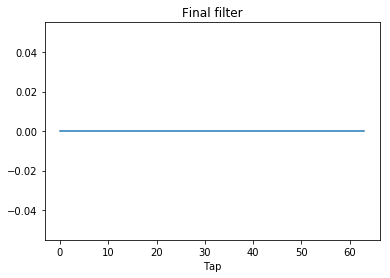

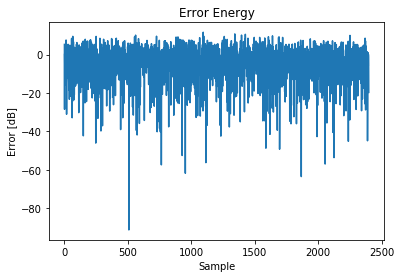

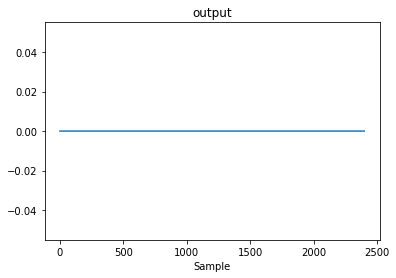

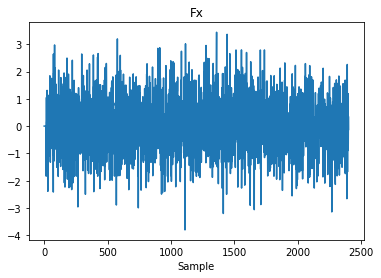

In [8]:
from adafilt import SimpleFilter

blocklength = n  # length of I/O buffer and blocksize of filter
n_buffers = 150  # size of simulation

# white noise signal
signal = np.random.normal(0, 1, size=n_buffers * blocklength)

# the adaptive filter
filt = MultiChannelBlockLMS(
    Nout=Nout,
    Nin=Nin,
    Nsens=Nsens,
    length=nfilt,
    blocklength=blocklength,
)

# secondary path estimate has to account for block size
primary_path = SimpleFilter(h_pri, squeeze=False)
secondary_path = SimpleFilter(h_sec, squeeze=False)
plant_model = SimpleFilter(np.concatenate((np.zeros((blocklength, 1, 1)), h_sec)), sum_inputs=False, squeeze=False)

# aggregate signals during simulation
xlog = []
elog = []
wslog = []
ylog = []
fxlog = []

y = np.zeros((blocklength, Nout))  # control signal is zero for first block
for i in range(n_buffers):

    x = np.random.normal(size=(blocklength, Nin))
    d = primary_path(x)
    u = secondary_path(y)
    e = d - u

    # filter the reference signal
    fx = plant_model(x)

    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    fxlog.append(fx)
    ylog.append(y.copy())
    wslog.append(filt.w)

plt.title("Final filter")
plt.plot(filt.w.reshape(nfilt, -1))
plt.xlabel("Tap")

plt.figure()
plt.title("Error Energy")
plt.plot(10 * np.log10(np.array(np.concatenate(elog)) ** 2))
plt.xlabel("Sample")
plt.ylabel("Error [dB]")

plt.figure()
plt.title("output")
plt.plot(np.concatenate(ylog))
plt.xlabel("Sample")

plt.figure()
plt.title("Fx")
plt.plot(np.concatenate(fxlog).reshape(blocklength * n_buffers, -1))
plt.xlabel("Sample")

plt.show()

In [113]:
%debug

> /home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/__init__.py(531)adapt()
    529         E = np.fft.fft(
    530             np.concatenate(
--> 531                 (np.zeros((self.length, self.Nsens)), np.concatenate(self.eadaptbuff))
    532             )
    533         )

ipdb> [x.shape for x in self.eadaptbuff]
[(16, 1), (16, 1), (16, 1), (16,)]
ipdb> e.shape
(16,)
--KeyboardInterrupt--
ipdb> q


In [89]:

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14, 8), constrained_layout=True)

ax[0, 0].set_title("Signals")
ax[0, 0].plot(np.concatenate(xlog), label="x", alpha=1)
ax[0, 0].plot(np.concatenate(ylog), label="y", alpha=0.8)
ax[0, 0].plot(np.concatenate(elog), label="e", alpha=0.7)
ax[0, 0].set_xlabel("Sample")
ax[0, 0].legend()

ax[0, 1].set_title("Filter weights")
ax[0, 1].plot(wslog)
ax[0, 1].set_xlabel("Block")


ax[1, 0].set_title("Error Energy")
ax[1, 0].plot(10 * np.log10(np.array(np.concatenate(elog)) ** 2))
ax[1, 0].set_xlabel("Sample")
ax[1, 0].set_ylabel("Error [dB]")


ax[1, 1].set_title("Final filter")
ax[1, 1].plot(filt.w)
ax[1, 1].set_xlabel("Tap")

plt.show()

> /home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/utils.py(110)olafilt()
    108     if zi is not None:
    109         zi = atleast_2d(zi)
--> 110         res[: zi.shape[0]] = res[: zi.shape[0]] + zi
    111         y = res[:L_sig]
    112         zf = res[L_sig : L_sig + L_I - 1]

ipdb> u
> /home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/__init__.py(499)filt()
    497         x = atleast_2d(x)
    498         assert x.shape[0] == self.blocklength
--> 499         y, self.zifilt = olafilt(self.w, x, zi=self.zifilt, squeeze=False)
    500         return y
    501 

ipdb> self.zifilt.shape
(127, 1, 1, 1)
ipdb> d
> /home/fhchl/dtuCloud/PhD/Subprojects/software/adafilt/adafilt/utils.py(110)olafilt()
    108     if zi is not None:
    109         zi = atleast_2d(zi)
--> 110         res[: zi.shape[0]] = res[: zi.shape[0]] + zi
    111         y = res[:L_sig]
    112         zf = res[L_sig : L_sig + L_I - 1]

ipdb> zi.shape
(127, 1, 1, 1)
ipdb> res.shape
(144, 3)
i